In [1]:
import numpy as np
import numpy.random as rd 
import numpy.linalg as la
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

## Variational Monte Carlo for Helium atom

## Differential operators

Some useful differential operators are introduced, notably the Laplace operator in orthogonal cartesian coordinates and the laplacian radial contribution in polar spherical coordinates.

\begin{align}
\nabla^2_{(x,y,z)} = \partial^2_x + \partial^2_y + \partial^2_z \\
\nabla^2_r = \partial^2_r + \frac{2}{r}\partial_r
\end{align}

Eventually I chosen to make the laplacian work only for a single point at a time. This is due to python implicitly assigning dimension (N,) to 1-D arrays (insted of explicitly assigning double dimension (N,1) ).\
Double dimension can still be assigned, explicitly, but has to be done everywhere to avoid unexpected behavior in nested calls.\
I found it easier to just create an array containing laplacian computed at different locations with a list comprehension :\
**lap_array = np.array( [laplacian(f,point[i]) for i in range(len(point)] )**

In [2]:
def laplacian(f, coords, dx=0.0001):
    '''Compute the Laplacian in cartesian orthogonal coordinates
    in a given point specified by coords.
    As long as the coordinate system is orthogonal, this laplacian
    works in any dimension. 
    '''
    lap = 0.
    
    for i in range(len(coords)):
        c_p = coords.copy()
        c_p[i] += dx 
        c_m = coords.copy()
        c_m[i] -= dx
        lap += ( f(c_p) -2.*f(coords) + f(c_m) ) / dx**2.
    return lap

def rad_laplacian(f, coords, dr=0.0001):
    '''
    Compute the radial contribution of the Laplacian in
    spherical polar coordinates.
    Function f can also depend on other variables, but it is 
    assumed here that the first variable is the radial distance 
    from the origin.
    '''
    rad_lap = np.empty(len(coords))
    
    for i in range(len(coords)):
        temp = coords[i].copy()
        temp_p = temp.copy()
        temp_p[0] += dr
        temp_m = temp.copy()
        temp_m[0] -= dr 
        rad_lap[i] = ( f(temp_p) - f(temp_m) ) / (temp[0]*dr) 
        rad_lap[i] += (f(temp_p) - 2.*f(temp) + \
                   f(temp_m)) / (dr**2.)
    return rad_lap

In [ ]:
# This example show how the radial laplacian works ...
# ... Or better it show if it works :)
def f(r):
    return 1./np.abs(r)

r = np.empty((1000,1))
r[:,0] = np.linspace(1.,2.,1000)
lap_r = rad_laplacian(f, r, dr=1e-4)

plt.close('all')
plt.xlabel(r'$r$')
plt.ylabel(r'$f(r)$')
plt.plot(r, f(r), label= r'$f(r) = \frac{1}{r}$')
plt.plot(r, lap_r, label= r'$\nabla ^2f$')
plt.legend()
plt.show()

In [ ]:
def f(x):
    return x[0]**2. 

xy = np.empty((100,2))
for i in range(100):
    xy[i] = np.array((i*0.5,0.))
l = laplacian(f,xy[0])
print(l)

fig,ax = plt.subplots()
l = np.array( [ laplacian(f,xy[i]) for i in range(len(xy)) ] )
_ = ax.plot(xy[:,0], xy[:,0]**2., label=r'$f = x^2$')
_ = ax.plot(xy[:,0], l, label=r'$\nabla^2f$')
_ = ax.legend()

## Markov Chain

A Markov chain is built up as a class object to evolve the system in the configuration space through Monte Carlo Metropolis algorithm.

In general this object can be defin through:
- **init_point** : the starting point of the chain, passed as an array.
- **prob_dist** : the asymptotic probability distribution of the chain, passed as a function object.
- **d** : the virtual displacement in the configuration space.

The method **set_chain** initialize the Markov chain as an array whose rows are given by the number of steps (plus one) required and whose columns store the phase space values that describe the system at each step.

The method **evolve_chain** is then use to evolve the Markov Chain in phase space using Metropolis algorithm. At each step only one of the configuration variables is randomly selected and displaced in parameters space. Then  the state is accepted or rejected. If the parameter **save** is set to **True** then init_point is substitued by the last point of the chain (I found this useful during the equilibration sequence).

The **evaluate_observable** method evaluates a given observable (passed as a function object) on the points of the evolved Markov Chain and returning an array of these values (I found it useful to put it this way in order to evaluate different observables on the same chain).

In [3]:
class MarkovChain:
    '''Class describing a Markov Chain in phase space,
       starting at init_point and with asymptotic probability 
       distribution given by prob_dist'''
    #
    #
    #
    def __init__(self, init_point=np.empty((1,1)), prob_dist=None, d=0.) :
        self.init_point = init_point     #initial point in phase space 
        self.prob_dist = prob_dist       #asymptotic probability distribution
        self.d = d                       #displacement takes place in [-d,d)
        self.steps = 0                   #Markov chain steps
        self.chain = np.empty(0)         #Store Markov chain entries
        self.acceptance_ratio = 0.       
    #
    #
    #
    def set_chain(self, steps):
        if ( len(self.init_point) != 0 ) :
            self.steps = steps
            self.chain = np.empty( (self.steps + 1 , len(self.init_point)) )
            return
        else:
            return
    #
    #
    #
    def evolve_chain(self, save = False):
        #failsafe
        if self.steps == 0 :
            return
        
        #start from init_point
        self.chain[0] = self.init_point
        n = len(self.init_point)
        count = 0
        
        for k in range(1,self.steps+1): 
            #Extract one of the parameters
            nu = rd.randint(low=0, high=n)
            
            #Random displacement of nu-th parameter
            self.chain[k] = self.chain[k-1].copy()
            self.chain[k,nu] += self.d * (2.* rd.uniform() - 1.)
            
            #Compute acceptance rate
            wt = self.prob_dist(self.chain[k]) / self.prob_dist(self.chain[k-1])
            
            #Evaluate if accepting the state ... 
            if (wt >= rd.uniform() ) :
                count += 1
            # ... or deny it
            else :
                self.chain[k,nu] = self.chain[k-1,nu]
        
        #Compute acceptance ratio 
        self.acceptance_ratio = count / self.steps
        
        #If save is true, change init_point with the last entry
        if (save == True) :
            self.init_point = self.chain[-1,:] 
        
        return
    #
    #
    #
    def evaluate_observable(self, observable):
        '''Evaluate an observable on the Markov chain elements'''
        obs = np.array([observable(self.chain[i]) for i in range(self.steps+1)])
        return obs

## Bootstrap 

A **bootstrap** algorithm extracts a random sample from a set of (statistical) data. The same object may also be sampled more than once. The idea behind the algorithm is to simulate the acquisition of the same set of data again and again in order to study how statisctical variables (**replicates**) may vary.  

In [4]:
def bootstrap_rep(data, func):
    bs_sample = rd.choice(data, len(data))
    return func(bs_sample)

## Harmonic Oscillator example

The 1-D Harmonic Oscillator example is studied to understand how the algorithm works and to compare the results with a known example. The trial wave function is taken as

$$\psi_0(x) = e^{-\alpha x},$$

with variational parameter $\alpha$. As we are interested in determining the parameter $\alpha$ normalization consatant are unimportant.\
The energy functional is defined as 

$$E[\psi;\alpha] = \frac{\int dx\,\psi(x;\alpha)^*H(x)\psi(x;\alpha)}{\int dx\,\psi(x;\alpha)^*\psi(x;\alpha)} = \frac{\int dx\,\psi(x;\alpha)^*H(x)\psi(x;\alpha)}{\int dx\,|\psi(x;\alpha)|^2}.$$

By defining the local energy as 

$$E_L(x;\alpha) = \frac{H(x)\psi(x;\alpha)}{\psi(x;\alpha)},$$

and a weight function 

$$\omega(x;\alpha) = \frac{|\psi(x;\alpha)|^2}{\int dx\,|\psi(x;\alpha)|^2},$$

the energy functional can be rewritten as: 

$$E[\psi] = \int dx \, \omega(x;\alpha)E_L(x;\alpha) \,= \,<E_L>_{\alpha}.$$

Thus the integral is interpreted as the mean value of the local energy $E_L$ with probability distribution given by $\omega$. For a given value of $\alpha$ the mean value can be evaluated using the MC Metropolis algorithm. 

In [ ]:
def set_HO_wfc(a):
    #
    def HO_wfc(x):
        return np.exp(-a * x**2.)
    #
    return HO_wfc

def Hamiltonian_ho(psi, x):
    '''Apply the Hamiltonian operator on a given psi'''
    ham = -0.5 * laplacian(psi, x) + 0.5 * x**2. * psi(x)
    return ham

def set_local_energy(psi):
    #
    def local_energy(x):
        return Hamiltonian_ho(psi,x) / psi(x)
    #
    return local_energy

def set_analytic_local_energy(a):
    #
    def analytic_local_energy(x):
        return ( a + x**2.*(0.5 - 2*a**2.) )
    #
    return analytic_local_energy

def set_weight(psi):
    #
    def weight(coords):
        w = psi(coords)*psi(coords)
        return w
    #
    return weight

### One run example

In [ ]:
if __name__ == '__main__' :
    #Compute <E_L> for a given alpha 
    
    a = 0.45
    psi = set_HO_wfc(a)       #define wave function
    w = set_weight(psi)       #define weight function
    E = set_local_energy(psi)
    E_a = set_analytic_local_energy(a)
    
    steps = 10000
    init_point = np.empty(1)      
    init_point[0] = 2.
    energies = np.empty(steps+1)     #array to store local energies 
    energies_a = np.empty(steps+1)
    coords = np.empty(steps+1)       #array to store coordinates out of Markov chain
    
    x_chain = MarkovChain(init_point, prob_dist=w, d=0.5)
    x_chain.set_chain(steps)                 #initialize Markov chain
    x_chain.evolve_chain(save=True)          #equilibration  
    print('After equilibration the starting point is ', x_chain.init_point)
    x_chain.evolve_chain()               #run 
    coords = x_chain.chain
    energies = x_chain.evaluate_observable(E)
    energies_a = x_chain.evaluate_observable(E_a)
    x_chain.init_point = init_point      #reset starting point
    
    #statistical analysis 
    mean = np.mean(energies)
    var = np.var(energies)
    print('Parameter   : %3.2f' % a)
    print('Acceptance Ratio : %5.4f' % x_chain.acceptance_ratio)
    print('Mean energy : %10.8f' % mean)
    print('Variance : %10.8f' % var)
    print('------------------------')
    
    #bootstrap
    reps = 10000
    mean_reps = np.empty(reps)
    for i in range(reps):
        mean_reps[i] = bootstrap_rep(energies[:,0], np.mean)
    print('BS Mean Energy  : %10.8f' % np.mean(mean_reps))
    # errr around mean values is determined with 95% confidence interval
    percs = np.percentile(mean_reps, [2.5,97.5])
    print('95%% C.I. length : %10.8f' % (percs[1]-percs[0]))
    
    #graphics 
    plt.close('all')
    fig, ax = plt.subplots(4,1, figsize=(12,9))
    plt.subplots_adjust(hspace=0.5)
    
    ax[0].set_title('States distribution in coordinate space\na = %3.2f' % a)
    ax[0].set_xlabel(r'$x$')
    ax[0].set_ylabel(r'$P(x)$')
    ax[0].hist(coords, bins=200, density=True, label='Numerical density')
    ax[0].plot(coords, np.sqrt(2*a/np.pi) * np.exp(-a*coords**2.)**2., label='Analytical density', lw=0.75)
    ax[0].legend()
    
    ax[1].set_title('Energy distribution')
    ax[1].set_xlabel(r'$E (a.u)$')
    ax[1].set_ylabel(r'$P(E)$')
    ax[1].set_xlim(0.4,0.6)
    ax[1].hist(energies, bins=200, density=True, label='Numeric Local Energy', alpha=0.5)
    ax[1].hist(energies_a, bins=200, density=True, label='Analytical Local Energy', alpha=0.5)
    ax[1].axvline(x=np.mean(energies), color='r', label= r'$<E> = %4.3f$' % np.mean(energies), alpha=0.5)
    ax[1].axvline(x=np.mean(energies_a), color='coral', label= r'$<E_A> = %4.3f$' % np.mean(energies_a), alpha=0.5)
    ax[1].legend()
    
    ax[2].set_title('Energy evolution during run')
    ax[2].set_xlabel(r'$\tau$')
    ax[2].set_ylabel(r'$E (a.u)$')
    ax[2].set_xlim(0,steps+1)
    ax[2].plot(range(steps+1), energies[:,0])
    ax[2].axhline(y=np.mean(energies), color='r', label=r'$<E> = %4.3f$' % np.mean(energies))
    ax[2].legend()
    
    ax[3].set_title('Bootstrap analysis')
    ax[3].set_xlabel('Mean Energy (a.u)')
    ax[3].set_ylabel(r'$P(E)$')
    ax[3].hist(mean_reps, bins=200, density=True)
    ax[3].axvline(x = np.mean(mean_reps), color='r', label = 'Mean Avg Energy = %5.4f' % np.mean(mean_reps))
    #percentiles 
    bounds = np.percentile(mean_reps, [2.5,97.5])
    ax[3].axvline(x = bounds[0], color='coral', label='95% confidence interval')
    ax[3].axvline(x = bounds[1], color='coral')
    ax[3].legend()
    
    plt.show()

### Varying parameters example 

In [ ]:
def evaluate_mean_energy(a, n_val, steps=10000, d=0.5, bs=False) :
    #Compute <E_L> for a given alpha 
    
    psi = set_HO_wfc(a)       #define wave function
    w = set_weight(psi)       #define weight function
    E = set_local_energy(psi)
    
    init_point = np.empty(1)      
    init_point[0] = 2.
    energies = np.empty((steps+1, n_val))     #array to store local energies 
    
    x_chain = MarkovChain(init_point, prob_dist=w, d=d)
    x_chain.set_chain(steps)                 #initialize Markov chain
    for i in range(n_val):
        x_chain.evolve_chain(save=True)      #equilibration   
        x_chain.evolve_chain()               #run 
        energies[:,i] = x_chain.evaluate_observable(E)[:,0]
        x_chain.init_point = init_point      #reset starting point
    
    #statistical analysis 
    mean_energies = np.mean(energies, axis=0)
    best_mean = np.mean(mean_energies)
    #variances = np.var(energies, axis=0)
    #var = np.mean(variances)
    percs = np.percentile(mean_energies, [2.5,97.5])
    var = percs[1] - percs[0]
    print('With %d runs : ' % n_val)
    print('Parameter    : %3.2f' % a)
    print('Acceptance Ratio : %5.4f' % x_chain.acceptance_ratio)
    print('Mean energy      : %10.8f' % best_mean)
    print('Variance         : %10.8f' % var)
    print('------------------------')
    
    #bootstrap analysis
    reps = 1000
    rep_mean = np.empty(reps)
    for i in range(reps):
        rep_mean[i] = bootstrap_rep(energies[:,0],np.mean)
    print('From Bootstrap analysis:')
    print('Mean energy is given by %10.8f' % np.mean(rep_mean) )
    percs = np.percentile(rep_mean, [2.5,97.5])
    diff = percs[1]-percs[0]
    print('Average variance on Energy is %10.8f' % diff)
    print('**************************************')
    
    if bs == True:
        return np.mean(rep_mean), diff*0.5
    else:
        return best_mean, var*0.5

In [ ]:
if __name__ == '__main__':
    # without bootstrap
    n_a = 10
    n_val = 10
    a = np.linspace(0.1,1.,n_a)
    mean_energies = np.empty(len(a))
    variances = np.empty(len(a))
    
    for i in range(n_a):
        mean_energies[i], variances[i] = evaluate_mean_energy(a[i], n_val, steps=10000, d=1.5, bs=False)
    
    indx_min = np.argmin(mean_energies)
    print('Min value is obtained for a = %4.3f' % a[indx_min])
    print('Min energy            E_min = %10.8f' % mean_energies[indx_min])

In [ ]:
if __name__ == '__main__':
    # with bootstrap
    n_a = 10
    n_val = 10
    a = np.linspace(0.1,1.,n_a)
    mean_energies_bs = np.empty(len(a))
    variances_bs = np.empty(len(a))
    
    for i in range(n_a):
        mean_energies_bs[i], variances_bs[i] = evaluate_mean_energy(a[i], n_val, steps=10000, d=1.5, bs=True)
    
    indx_min = np.argmin(mean_energies_bs)
    print('Min value is obtained for a = %4.3f' % a[indx_min])
    print('Min energy            E_min = %10.8f' % mean_energies_bs[indx_min])

In [ ]:
#graphics
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5)
_ = ax[0].set_title('Mean local energy')
_ = ax[0].set_xlabel(r'$\alpha$')
_ = ax[0].set_ylabel(r'$<E_L>$')
_ = ax[0].errorbar(a, mean_energies, yerr=np.sqrt(variances), ecolor='r', linestyle='none', marker='.', alpha=0.5,
                  label='Brute Force', color='r')
_ = ax[0].errorbar(a, mean_energies_bs, yerr = variances_bs, ecolor='b', linestyle='none', marker='.',
                  label='Bootstrap', alpha=0.5)
_ = ax[0].legend()

_ = ax[1].set_yscale('log')
_ = ax[1].set_title('Variance')
_ = ax[1].set_xlabel(r'$\alpha$')
_ = ax[1].set_ylabel(r'$(\Delta E)^2$')
_ = ax[1].plot(a, np.sqrt(variances), marker='.', alpha=0.5)
_ = ax[1].plot(a, variances_bs, marker='.', color='coral', alpha=0.5)
plt.show()

## Helium atom

In atomic units, and neglecting spin effects, the Hamiltonian of the Helium atom is given by :

$$H = -\frac{1}{2}\nabla^2_1  -\frac{1}{2}\nabla^2_2 - \frac{2}{r_1} - \frac{2}{r_2} + \frac{1}{r_{12}}$$.

As it was done in the example of the harmonic oscillator, the ground state is determined through variational approach, starting by a trial function depending on some parameter and looking for the parameter value (on a mesh) that minimizes the energy functional.

In [5]:
class Helium:
    
    def __init__(self, coords=np.empty((1,6)), params=[0.,0.]):
        self.name = 'Helium' 
        self.coords = coords
        self.set_r(coords)             #Define radial vectors of the two electrons
        self.set_params(params)        #Variational parameters 
        self.set_potential()           
        self.set_WF()
        self.set_weight()
        self.set_local_energy()
    
    def set_r(self, coords):
        r1 = np.array(coords[:3])
        r2 = np.array(coords[3:])
        r12 = r1 - r2 
        self.r1 = la.norm(r1)
        self.r2 = la.norm(r2)
        self.r12 = la.norm(r12)
    
    def set_params(self, params):
        self.params = params
        
    def set_potential(self, interacting=True):
        if (interacting==True):
            def V(coords):
                Z = 2.         #potential must not be parametrized
                self.set_r(coords)
                V = - Z * (1./self.r1 + 1./self.r2) + 1./self.r12
                return V 
        else:
            def V(coords):
                Z = 2.         #potential must not be parametrized
                self.set_r(coords)
                V = - Z * (1./self.r1 + 1./self.r2)
                return V
        self.V = V
    
    def set_WF(self, jastrow=True):
        Z = self.params[0]      #wave function must be parametrized
        b = self.params[1]
        if (jastrow == True):
            def WF(coords):
                self.set_r(coords)
                wf = np.exp(- Z * self.r1) * np.exp(- Z * self.r2) *\
                     np.exp(0.5 * self.r12 / (1 + b*self.r12) ) 
                return wf
        else:
            def WF(coords):
                self.set_r(coords)
                wf = np.exp(- Z * self.r1) * np.exp(- Z * self.r2)
                return wf
        self.WF = WF
        return
    
    def set_weight(self):
        def weight(coords):
            w = self.WF(coords)*self.WF(coords)
            return w
        self.weight = weight
        return
    
    def set_local_energy(self):
        def EL(coords):
            el = - 0.5 * laplacian(self.WF, coords) 
            el /= self.WF(coords) 
            el += self.V(coords)
            return el
        self.EL = EL

## Test : correct working of Helium class

In [ ]:
def loc_en_ni(coords):
    Z = 2.
    r1 = la.norm(coords[:3])
    r2 = la.norm(coords[3:])
    el =  - Z * ( - (1./r1 + 1./r2) + Z )
    el += -Z * (1./r1 + 1./r2)
    return el

def set_loc_en_i(b):
    
    def loc_en_i(coords):
        r1_v = np.array(coords[:3])
        r2_v = np.array(coords[3:])
        r12_v = r1_v - r2_v
        r1 = la.norm(r1_v)
        r2 = la.norm(r2_v)
        r12 = la.norm(r12_v)
    
    
        Z=2.
        a=0.5
    
        el = -Z**2. + (Z-2.)/r1 + (Z-2.)/r2 +\
             1./r12 * (1. - 2.*a/((1.+b*r12)**2.) ) +\
             2.*a*b/((1.+b*r12)**3.) - a**2./((1. + b*r12)**4.) +\
             Z*a/((1. + b*r12)**2.) * np.dot(r12_v/r12, r1_v/r1 - r2_v/r2)
        return el
    
    return loc_en_i

In [ ]:
Z = 2.         #Nuclear charge
b = 0.5        #variational parameter
parameters = np.array([Z, b])
He = Helium(params=parameters)
coords = np.array([0.,0.,4., 0.,3.,0.])
He.set_r(coords)
print('Distance of e1 from nucleus is %10.8f' % He.r1)
print('Distance of e2 from nucleus is %10.8f' % He.r2)
print('Distance between e1 and e2  is %10.8f' % He.r12)

In [ ]:
#non interacting electrons
r1 = He.r1
r2 = He.r2
print('Non interacting electrons')
He.set_potential(interacting=False)
He.set_WF(jastrow=False)

He.set_r(coords)
He.coords = coords
print('Numerical potential is %10.8f, analytical is [%10.8f]' % (He.V(He.coords),-2.*(1./r1 +1./r2)) )
print('Numerical WF        is %10.8f, analytical is [%10.8f]' % (He.WF(He.coords), np.exp(-Z*r1)*np.exp(-Z*r2)))
print('Numerical LE        is %15.14f, analytical is [%15.14f]' % (He.EL(He.coords), loc_en_ni(coords)) )
print('Numerical weight    is %10.8e, analytical is [%10.8e]' % (He.weight(He.coords), np.exp(-2.*Z*(r1 + r2))))
print('-----------------------------------------------------------------------------')

In [ ]:
#interacting electrons
r1 = He.r1
r2 = He.r2
r12 = He.r12
print('Interacting electrons')
loc_en = set_loc_en_i(b)

He.coords = coords
He.set_potential()
He.set_WF()
He.set_r(coords)
He.set_weight()
print('Numerical potential is %10.8f, analytical is [%10.8f]' % (He.V(He.coords),-2.*(1./r1 + 1./r2) +\
                                                                 1./r12 ) )
print('Numerical WF        is %10.8f, analytical is [%10.8f]' % (He.WF(He.coords), np.exp(-Z*r1)*\
                                                                 np.exp(-Z*r2)*np.exp(0.5*r12/(1.+b*r12)) ))
print('Numerical EL        is %10.8f, analytical is [%10.8f]' % (He.EL(He.coords), loc_en(coords)))
print('Numerical weight    is %10.8e, analytical is [%10.8e]' % (He.weight(He.coords), He.WF(He.coords)**2.))
print('-----------------------------------------------------------------------------')

## One run Helium

In [ ]:
if __name__ == '__main__':
    # The configuration space in this example is 
    # taken to be R6 (three cartesian coordinates per electron)
    p0 = np.array([1.,0.,0.,2.,3.,0.])         #starting point for the Markov chain
    Z = 1.5
    b = 0.5
    params = [Z, b]                            #fixing variational parameter
    He = Helium(p0, params)                    #creating Helium instance
    He.set_potential(interacting=True)
    He.set_WF(jastrow=True)          
    He.set_local_energy()
    He.set_weight()                          
    
    p_dist = He.weight                         #define probability density function
    d = 0.75                                   #define half width displacements for Metropolis
    steps = 10000                              #define number of steps for Metropolis
    
    r6_chain = MarkovChain(init_point=p0, prob_dist = p_dist, d = d)
    r6_chain.set_chain(steps)
    
    #equilibration
    r6_chain.evolve_chain(save=True)
    print('After equilibration electrons positions are given by:')
    print('e1 : ' , r6_chain.init_point[:3])
    print('e2 : ' , r6_chain.init_point[3:])
    
    #actual run
    r6_chain.set_chain(steps)
    r6_chain.evolve_chain()
    
    #electrons position are now stored in r6_chain.chain !
    
    energies_num = r6_chain.evaluate_observable(He.EL)
    loc_en = set_loc_en_i(b)
    energies_a   = r6_chain.evaluate_observable(loc_en)

In [ ]:
#3D graphics
fig = plt.figure()
#ax = fig.add_subplot(projection = '3d')
ax1 = Axes3D(fig)

x1 = r6_chain.chain[:,0]
y1 = r6_chain.chain[:,1]
z1 = r6_chain.chain[:,2]

x2 = r6_chain.chain[:,3]
y2 = r6_chain.chain[:,4]
z2 = r6_chain.chain[:,5]

_ = ax1.set_title('Electrons probability distribution')
_ = ax1.set_xlabel(r'$x$')
_ = ax1.set_ylabel(r'$y$')
_ = ax1.set_zlabel(r'$z$')
_ = ax1.plot([0.],[0.],[0.], marker='.', color='r')
_ = ax1.plot(x1, y1, z1, marker='.', linestyle='none', alpha=0.05)
_ = ax1.plot(x2, y2, z2, marker='.', linestyle='none', alpha=0.05)

In [ ]:
fig, ax = plt.subplots()
#print(energies_num.shape, energies_a.shape)
_ = ax.set_title('Energies distribution')
_ = ax.set_xlabel(r'$E \,(a. u.)$')
_ = ax.set_ylabel(r'$P(E)$')
_ = ax.hist(energies_num, bins=200, density=True, label='Numeric', alpha=0.5)
_ = ax.hist(energies_a, bins=200, density=True, label='Analytical', alpha=0.5)
ax.legend()
plt.show()

## Varying parameters Helium

In [6]:
def evaluate_energy_He(params, p0='default', steps=10000, d=0.5, 
                       bs_samples=10000, talky=False):
    # The configuration space in this example is 
    # taken to be R6 (three cartesian coordinates per electron)
    if p0 == 'default' :
        p0 = np.array([1.,0.,0.,2.,3.,0.])         #starting point for the Markov chain
    He = Helium(p0, params)                        #creating Helium instance
    He.set_potential(interacting=False)
    He.set_WF(jastrow=False)          
    He.set_local_energy()
    He.set_weight()                          
    
    p_dist = He.weight                         #define probability density function
    
    r6_chain = MarkovChain(init_point=p0, prob_dist = p_dist, d = d) #Markov Chain instance
    r6_chain.set_chain(steps)                                        
    
    #equilibration
    r6_chain.evolve_chain(save=True)
    
    #actual run
    r6_chain.evolve_chain()
    
    #evaluating energy on sampled states
    energies = r6_chain.evaluate_observable(He.EL)
    
    #Bootstrapping
    mean_energies = np.empty(bs_samples)
    for i in range(bs_samples):
        mean_energies[i] = bootstrap_rep(energies, np.mean)
    best_energy = np.mean(mean_energies)
    percs = np.percentile(mean_energies, [2.5,97.5])
    
    # if you feel talkative this prints a lot of infos ;)
    if talky==True :
        print('Z     : %4.3f' % params[0])
        print('b     : %4.3f' % params[1])
        print('Steps : %d' % r6_chain.steps)
        print('Acceptance ratio : %7.6f' % r6_chain.acceptance_ratio)
        print('Average Energy   : %10.9f' % best_energy)
        print('95 %% C.I.       : %10.9f' % (percs[1]-percs[0]))
        print('************************************************')
    return best_energy, percs[1]-percs[0]

In [7]:
if __name__ == '__main__':
    # varying Z 
    Z = np.linspace(1.,3.,11)
    #Z = np.array([1.5,27./16.,2.])
    #Z = np.full(10,2.)
    b = np.zeros(len(Z))
    params = np.empty((len(Z),2))
    params[:,0] = Z
    params[:,1] = b
    
    #arrays to store energy functional values
    # and uncertainties
    energies = np.empty(len(Z))
    uncertainties = np.empty(len(Z))
    
    for i in range(len(Z)):
        energies[i], uncertainties[i] = evaluate_energy_He(params[i], talky=True)
    

Z     : 1.000
b     : 0.000
Steps : 10000
Acceptance ratio : 0.874100
Average Energy   : -3.330552300
95 % C.I.       : 0.063137117
************************************************
Z     : 1.200
b     : 0.000
Steps : 10000
Acceptance ratio : 0.854100
Average Energy   : -3.234769780
95 % C.I.       : 0.046384559
************************************************
Z     : 1.400
b     : 0.000
Steps : 10000
Acceptance ratio : 0.832200
Average Energy   : -3.619175621
95 % C.I.       : 0.039675257
************************************************
Z     : 1.600
b     : 0.000
Steps : 10000
Acceptance ratio : 0.807700
Average Energy   : -3.837572704
95 % C.I.       : 0.030649105
************************************************
Z     : 1.800
b     : 0.000
Steps : 10000
Acceptance ratio : 0.789600
Average Energy   : -3.973777283
95 % C.I.       : 0.017768127
************************************************
Z     : 2.000
b     : 0.000
Steps : 10000
Acceptance ratio : 0.761800
Average Energy   : -3.999

<IPython.core.display.Javascript object>


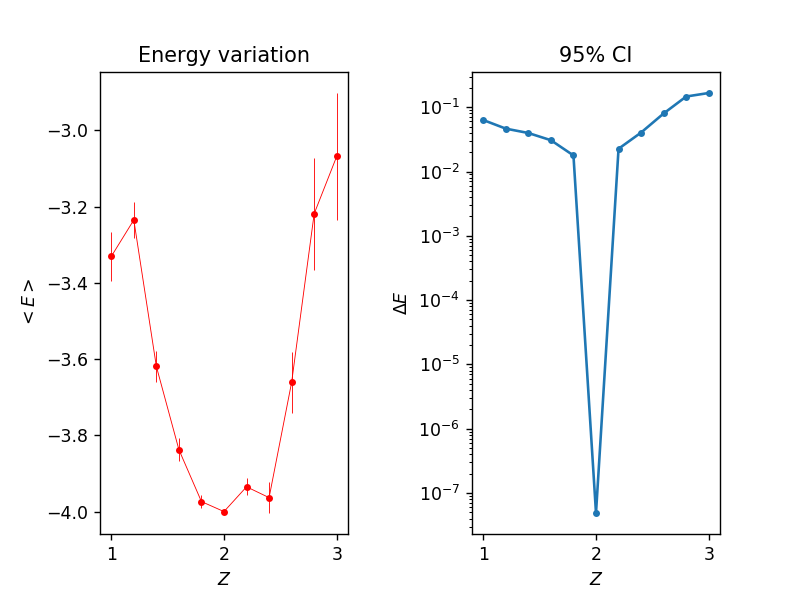

In [8]:
#graphics for the last example

fig, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.5)

_ = ax[0].set_title('Energy variation')
_ = ax[0].set_xlabel(r'$Z$')
_ = ax[0].set_ylabel(r'$<E>$')
_ = ax[0].errorbar(Z, energies, yerr=uncertainties, ecolor='r', marker='.', color='red',
                  linewidth = 0.5)

_ = ax[1].set_yscale('log')
_ = ax[1].set_title('95% CI')
_ = ax[1].set_xlabel(r'$Z$')
_ = ax[1].set_ylabel(r'$\Delta E$')
_ = ax[1].plot(Z, uncertainties, marker='.')

In [ ]:
27/16